In [1]:
import os
import pandas as pd
import numpy as np
import datetime as dt
from pathlib import Path
import yfinance as yf
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
from fuzzywuzzy import process
import requests

In [3]:
# Retrieve the NYtimes API key
nyt_api = os.getenv("NYT_SECRET_KEY")

In [4]:
company_request = 'tesla'

In [5]:
def getCompany(text):
    r = requests.get('https://api.iextrading.com/1.0/ref-data/symbols')
    stockList = r.json()
    return process.extractOne(text, stockList)[0]

In [6]:
company = getCompany(company_request)

In [7]:
symbol = company['symbol']
company_name = company['name']
print(symbol)
print(company_name)

TSLA
TESLA INC


In [8]:
data = yf.download(symbol, parse_dates=True, infer_datetime_format=True)

[*********************100%***********************]  1 of 1 downloaded


In [9]:
data['Daily Return'] = data['Close'].dropna().pct_change()

In [10]:
# Set short and long windows
short_window = 50
long_window = 100

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
data['fast_close'] = data['Close'].ewm(halflife=short_window).mean()
data['slow_close'] = data['Close'].ewm(halflife=long_window).mean()

# Construct a crossover trading signal
data['crossover_long'] = np.where(data['fast_close'] > data['slow_close'], 1.0, 0.0)
data['crossover_short'] = np.where(data['fast_close'] < data['slow_close'], -1.0, 0.0)
data['crossover_signal'] = data['crossover_long'] + data['crossover_short']

short_vol_window = 5
long_vol_window = 21

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
data['fast_vol'] = data['Daily Return'].ewm(halflife=short_vol_window).std()
data['slow_vol'] = data['Daily Return'].ewm(halflife=long_vol_window).std()

# Construct a crossover trading signal
data['vol_trend_long'] = np.where(data['fast_vol'] < data['slow_vol'], 1.0, 0.0)
data['vol_trend_short'] = np.where(data['fast_vol'] > data['slow_vol'], -1.0, 0.0) 
data['vol_trend_signal'] = data['vol_trend_long'] + data['vol_trend_short']

# Set bollinger band window
bollinger_window = 20

# Calculate rolling mean and standard deviation
data['bollinger_mid_band'] = data['Close'].rolling(window=bollinger_window).mean()
data['bollinger_std'] = data['Close'].rolling(window=20).std()

# Calculate upper and lowers bands of bollinger band
data['bollinger_upper_band']  = data['bollinger_mid_band'] + (data['bollinger_std'] * 1)
data['bollinger_lower_band']  = data['bollinger_mid_band'] - (data['bollinger_std'] * 1)

# Calculate bollinger band trading signal
data['bollinger_long'] = np.where(data['Close'] < data['bollinger_lower_band'], 1.0, 0.0)
data['bollinger_short'] = np.where(data['Close'] > data['bollinger_upper_band'], -1.0, 0.0)
data['bollinger_signal'] = data['bollinger_long'] + data['bollinger_short']

data

data.head()

,Open,High,Low,Close,Adj Close,Volume,Daily Return,fast_close,slow_close,crossover_long,...,vol_trend_long,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
Date,,,,,,,,,,,,,,,,,,,,,
2010-06-29,19.00,25.00,17.54,23.89,23.89,18766300,NaN,23.890000,23.890000,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2010-06-30,25.79,30.42,23.30,23.83,23.83,17187100,-0.002512,23.859792,23.859896,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2010-07-01,25.00,25.92,20.27,21.96,21.96,8218800,-0.078473,23.217729,23.222203,0.0,...,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2010-07-02,23.00,23.10,18.71,19.20,19.20,5139800,-0.125683,22.192315,22.206173,0.0,...,1.0,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2010-07-06,20.00,20.00,15.83,16.11,16.11,6866900,-0.160937,20.941893,20.969978,0.0,...,1.0,0.0,1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0


In [11]:
analyzer = SentimentIntensityAnalyzer()

In [12]:
import requests
import json
import time

In [13]:
response=[]
for i in range(100):
    try:
        request_url = "https://api.nytimes.com/svc/search/v2/articlesearch.json?q=" + company_name + "&page=" + str(i) + "&api-key=" + nyt_api
        
        response_data = requests.get(request_url).json()
        news_data = response_data['response']['docs']
        time.sleep(6)
        for x in news_data:
            response.append(x)
    except:
        pass

In [14]:
len(response)

1000

In [15]:
response2 = pd.DataFrame(response)

In [16]:
#response2

In [17]:
# Define a function to get the sentiment scores
def get_sentiment_scores(abstract, lead_paragraph, date, url):
    sentiment_scores = {}

    # Sentiment scoring with VADER
    text_sentiment = analyzer.polarity_scores(lead_paragraph)
    sentiment_scores["pub_date"] = date
    sentiment_scores["abstract"] = abstract
    sentiment_scores["lead_paragraph"] = lead_paragraph
#    sentiment_scores["source"] = source
    sentiment_scores["web_url"] = url
    sentiment_scores["compound"] = text_sentiment["compound"]
    sentiment_scores["pos"] = text_sentiment["pos"]
    sentiment_scores["neu"] = text_sentiment["neu"]
    sentiment_scores["neg"] = text_sentiment["neg"]
    if text_sentiment["compound"] >= 0.05:  # Positive
        sentiment_scores["normalized"] = 1
    elif text_sentiment["compound"] <= -0.05:  # Negative
        sentiment_scores["normalized"] = -1
    else:
        sentiment_scores["normalized"] = 0  # Neutral

    return sentiment_scores

In [18]:
# Empty list to store the DataFrame structure
sentiments_data = []

# Loop through all the news articles
for article in response:
    try:
        # Get sentiment scoring using the get_sentiment_score() function
        sentiments_data.append(
            get_sentiment_scores(
                article["abstract"],
                article["lead_paragraph"],
                article["pub_date"][:10],
#                article["source"],
                article["web_url"],
            )
        )

    except AttributeError:
        pass

# Create a DataFrame with the news articles' data and their sentiment scoring results
news_df = pd.DataFrame(sentiments_data)

# Sort the DataFrame rows by date
news_df = news_df.sort_values(by="pub_date")

# Define the date column as the DataFrame's index
news_df.set_index("pub_date", inplace=True)

In [19]:
news_sent = news_df[['compound','normalized']]
signal_data =  pd.concat([data, news_sent], axis=1)
signal_data.drop(signal_data.index[0], inplace=True)
signal_data.fillna(0, inplace=True)
signal_data= signal_data[signal_data.Open != 0]

In [20]:
signal_data

,Open,High,Low,Close,Adj Close,Volume,Daily Return,fast_close,slow_close,crossover_long,...,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,compound,normalized
2010-06-29,19.00,25.00,17.54,23.89,23.89,18766300.0,0.000000,23.890000,23.890000,0.0,...,0.0,0.0000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2010-06-30,25.79,30.42,23.30,23.83,23.83,17187100.0,-0.002512,23.859792,23.859896,0.0,...,0.0,0.0000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2010-07-01,25.00,25.92,20.27,21.96,21.96,8218800.0,-0.078473,23.217729,23.222203,0.0,...,-1.0,0.0000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2010-07-02,23.00,23.10,18.71,19.20,19.20,5139800.0,-0.125683,22.192315,22.206173,0.0,...,1.0,0.0000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2010-07-06,20.00,20.00,15.83,16.11,16.11,6866900.0,-0.160937,20.941893,20.969978,0.0,...,1.0,0.0000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-06,335.00,338.86,334.77,335.89,335.89,7612400.0,0.016709,276.959032,276.902407,1.0,...,1.0,341.3120,9.684103,350.996103,331.627897,0.0,0.0,0.0,0.0,0.0
2019-12-06,335.00,338.86,334.77,335.89,335.89,7612400.0,0.016709,276.959032,276.902407,1.0,...,1.0,341.3120,9.684103,350.996103,331.627897,0.0,0.0,0.0,0.0,0.0
2019-12-06,335.00,338.86,334.77,335.89,335.89,7612400.0,0.016709,276.959032,276.902407,1.0,...,1.0,341.3120,9.684103,350.996103,331.627897,0.0,0.0,0.0,0.0,0.0
2019-12-09,336.59,344.45,335.08,339.53,339.53,9023100.0,0.010837,277.820465,277.335008,1.0,...,1.0,341.4315,9.644577,351.076077,331.786923,0.0,0.0,0.0,0.0,0.0


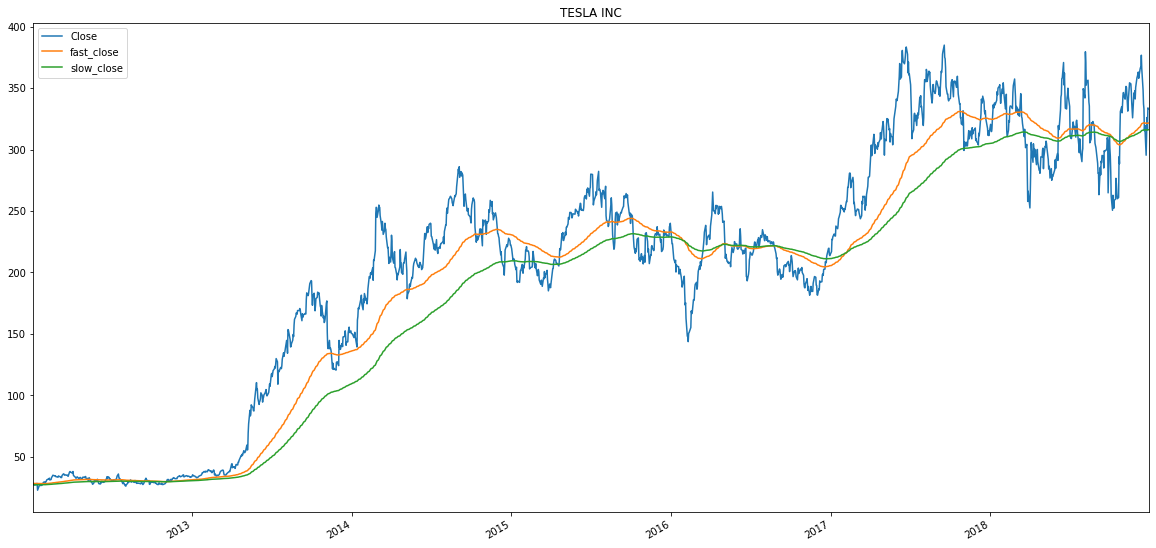

In [21]:
signal_data.loc['2012-01-01':'2019-01-01'][['Close', 'fast_close', 'slow_close']].plot(figsize=(20,10), title=company_name)

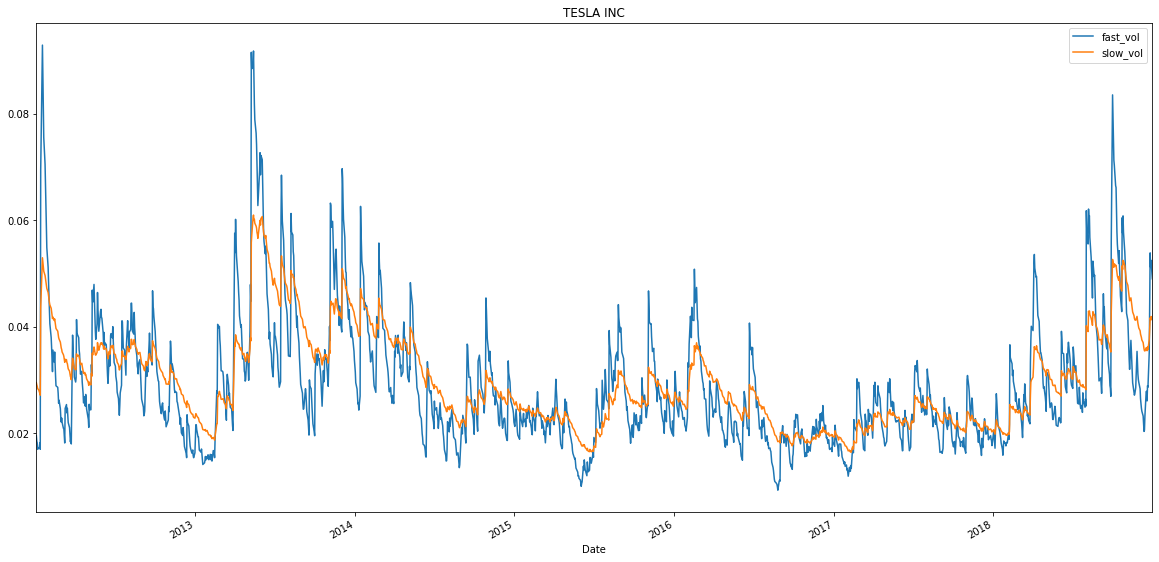

In [22]:
data.loc['2012-01-01':'2019-01-01'][['fast_vol', 'slow_vol']].plot(figsize=(20,10), title=company_name)

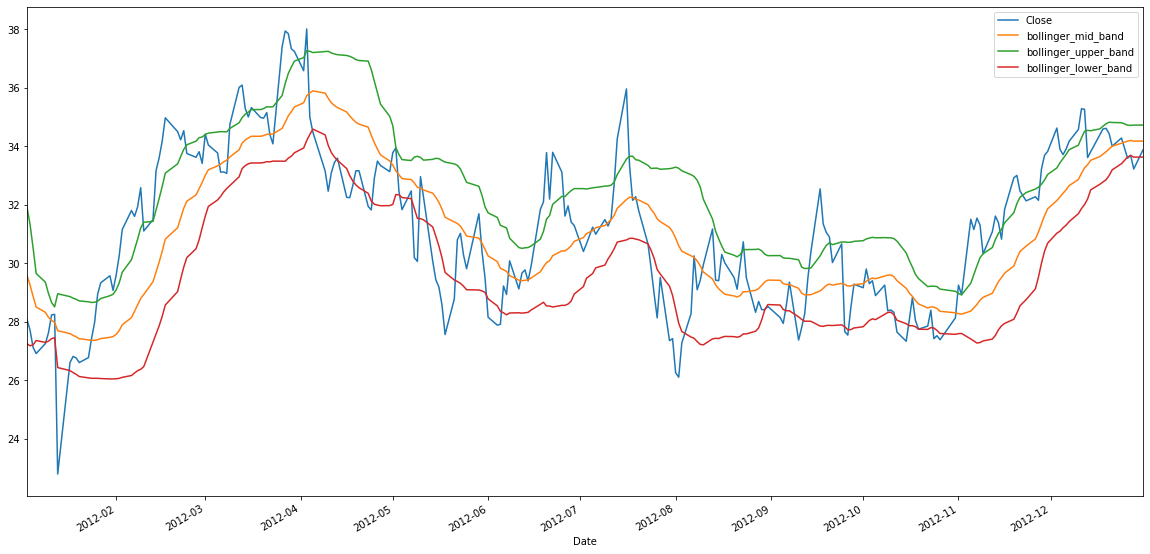

In [23]:
# Plot the Bollinger Bands for BTC/USD closing prices
data.loc['2012-01-01':'2013-01-01'][['Close','bollinger_mid_band','bollinger_upper_band','bollinger_lower_band']].plot(figsize=(20,10))

In [24]:
# Set x variable list of features
x_var_list = ['crossover_signal', 'vol_trend_signal', 'bollinger_signal', 'normalized']

# Filter by x-variable list
signal_data[x_var_list].tail()

,crossover_signal,vol_trend_signal,bollinger_signal,normalized
2019-12-06,1.0,1.0,0.0,0.0
2019-12-06,1.0,1.0,0.0,0.0
2019-12-06,1.0,1.0,0.0,0.0
2019-12-09,1.0,1.0,0.0,0.0
2019-12-10,1.0,1.0,0.0,0.0


In [27]:
signal_data[x_var_list] = signal_data[x_var_list].shift(1)
signal_data[x_var_list].tail()

,crossover_signal,vol_trend_signal,bollinger_signal,normalized
2019-12-06,1.0,1.0,0.0,0.0
2019-12-06,1.0,1.0,0.0,0.0
2019-12-06,1.0,1.0,0.0,0.0
2019-12-09,1.0,1.0,0.0,0.0
2019-12-10,1.0,1.0,0.0,0.0


In [31]:
#signal_dataand replace positive/negative infinity values
signal_data.dropna(subset=x_var_list, inplace=True)
signal_data.dropna(subset=['Daily Return'], inplace=True)
signal_data = signal_data.replace([np.inf, -np.inf], np.nan)
signal_data.head()

,Open,High,Low,Close,Adj Close,Volume,Daily Return,fast_close,slow_close,crossover_long,...,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,compound,normalized
2010-07-02,23.00,23.10,18.71,19.20,19.20,5139800.0,-0.125683,22.192315,22.206173,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-07-06,20.00,20.00,15.83,16.11,16.11,6866900.0,-0.160937,20.941893,20.969978,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-07-07,16.40,16.63,14.98,15.80,15.80,6921700.0,-0.019243,20.054938,20.093315,0.0,...,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-07-08,16.14,17.52,15.57,17.46,17.46,7711400.0,0.105063,19.668639,19.709259,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010-07-09,17.58,17.90,16.55,17.40,17.40,4050600.0,-0.003436,19.371110,19.413551,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
